# Xây dựng mô hình dự đoán khách hàng rời mạng viến thông

Giữ chân khách hàng là yếu tố then chốt cho sự thành công của một công ty, đặc biệt trong một ngành cạnh tranh như dịch vụ viễn thông. Thu hút khách hàng mới không chỉ khó khăn hơn mà còn tốn kém hơn nhiều so với việc duy trì mối quan hệ với khách hàng hiện tại. Trong dự án này, chúng tôi sẽ dự đoán khách hàng có ý định rời bỏ dịch vụ tại một công ty cung cấp dịch vụ viễn thông. Trước tiên, chúng tôi sẽ sử dụng phân tích dữ liệu thăm dò để hiểu các mối quan hệ giữa các đặc điểm và biến mục tiêu, và xác định các yếu tố có ảnh hưởng trong việc dự đoán sự rời bỏ của khách hàng. Sử dụng những đặc điểm này, chúng tôi sẽ phát triển một mô hình dự đoán để giúp công ty giảm tỷ lệ rời bỏ một cách chủ động và sử dụng những thông tin từ mô hình để củng cố các chiến lược giữ chân khách hàng.

## 1. Import thư viện

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## 2. Load dữ liệu

In [51]:
train_data = pd.read_csv('telecom_train.csv')
train_df = pd.DataFrame(data=train_data)

test_data = pd.read_csv('telecom_test.csv')
test_df = pd.DataFrame(data=test_data)

In [52]:
# show first 5 rows
pd.set_option('display.max_columns', None)
train_df.head(5)

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,Tenure in Months,Offer,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,Internet Service,Internet Type,Avg Monthly GB Download,Online Security,Online Backup,Device Protection Plan,Premium Tech Support,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,9,NaN,Yes,42.39,No,Yes,Cable,16.0,No,Yes,No,Yes,Yes,No,No,Yes,One Year,Yes,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,9,NaN,Yes,10.69,Yes,Yes,Cable,10.0,No,No,No,No,No,Yes,Yes,No,Month-to-Month,No,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,4,Offer E,Yes,33.65,No,Yes,Fiber Optic,30.0,No,No,Yes,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,13,Offer D,Yes,27.82,No,Yes,Fiber Optic,4.0,No,Yes,Yes,No,Yes,Yes,No,Yes,Month-to-Month,Yes,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,3,NaN,Yes,7.38,No,Yes,Fiber Optic,11.0,No,No,No,Yes,Yes,No,No,Yes,Month-to-Month,Yes,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


## 3. Phân tích dữ liệu


In [53]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5500 entries, 0 to 5499
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        5500 non-null   object 
 1   Gender                             5500 non-null   object 
 2   Age                                5500 non-null   int64  
 3   Married                            5500 non-null   object 
 4   Number of Dependents               5500 non-null   int64  
 5   City                               5500 non-null   object 
 6   Zip Code                           5500 non-null   int64  
 7   Latitude                           5500 non-null   float64
 8   Longitude                          5500 non-null   float64
 9   Number of Referrals                5500 non-null   int64  
 10  Tenure in Months                   5500 non-null   int64  
 11  Offer                              2472 non-null   objec

Dữ liệu từ tập training bao gồm 5500 bản ghi với 38 thuộc tính được chia thành hai loại: dữ liệu nhân khẩu học của khách hàng và thông tin liên quan đến dịch vụ viễn thông của họ. Các đặc điểm nhân khẩu học bao gồm giới tính, tình trạng hôn nhân, số người phụ thuộc, và tuổi tác của khách hàng. Các đặc điểm liên quan đến thông tin tài khoản bao gồm thời gian khách hàng đã gắn bó với dịch vụ, chi phí hàng tháng và tổng chi phí, loại hợp đồng (theo tháng, một năm, hoặc hai năm), và loại dịch vụ điện thoại, internet, TV. Biến mục tiêu của chúng tôi cho nghiên cứu này là tình trạng khách hàng, một biến phân loại biểu thị liệu khách hàng ở lại hay đã rời dịch vụ.


In [54]:
train_df.isnull().sum()

Customer ID                             0
Gender                                  0
Age                                     0
Married                                 0
Number of Dependents                    0
City                                    0
Zip Code                                0
Latitude                                0
Longitude                               0
Number of Referrals                     0
Tenure in Months                        0
Offer                                3028
Phone Service                           0
Avg Monthly Long Distance Charges     526
Multiple Lines                        526
Internet Service                        0
Internet Type                        1194
Avg Monthly GB Download              1194
Online Security                      1194
Online Backup                        1194
Device Protection Plan               1194
Premium Tech Support                 1194
Streaming TV                         1194
Streaming Movies                  

In [55]:
train_df.value_counts('Customer Status')

Customer Status
Stayed     3663
Churned    1482
Joined      355
Name: count, dtype: int64

Số liệu cho thấy có 3663 người tiếp tục sử dụng dịch vụ, 1482 người đã ngừng sử dụng, và 355 người mới tham gia. Tỷ lệ giữ chân khách hàng khá tốt, với số người ở lại cao hơn đáng kể so với số người rời đi. Tuy nhiên, số lượng khách hàng mới còn thấp, chỉ bằng khoảng 1/4 số người rời đi.

### Phân tích đơn biến

In [56]:
desc_df = train_df.describe(include=[object])
desc_df = desc_df.drop(columns=['Customer ID'])
desc_df

,Gender,Married,City,Offer,Phone Service,Multiple Lines,Internet Service,Internet Type,Online Security,Online Backup,Device Protection Plan,Premium Tech Support,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data,Contract,Paperless Billing,Payment Method,Customer Status,Churn Category,Churn Reason
count,5500,5500,5500,2472,5500,4974,5500,4306,4306,4306,4306,4306,4306,4306,4306,4306,5500,5500,5500,5500,1482,1482
unique,2,2,1102,5,2,2,2,3,2,2,2,2,2,2,2,2,3,2,3,3,5,20
top,Male,No,San Diego,Offer B,Yes,No,Yes,Fiber Optic,No,No,No,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,Stayed,Competitor,Competitor had better devices
freq,2792,2810,221,650,4974,2665,4306,2386,2758,2400,2420,2718,2184,2172,2371,3709,2828,3261,3075,3663,656,251


In [57]:
train_df.describe(include=[np.number])


,Age,Number of Dependents,Zip Code,Latitude,Longitude,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue
count,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,4974.000000,4306.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000
mean,46.512909,0.470727,93496.518364,36.215866,-119.767786,1.952000,32.263091,25.517214,26.221087,63.640282,2273.396062,1.834020,6.829091,749.343147,3027.734280
std,16.765165,0.963820,1852.150700,2.473192,2.157951,2.989505,24.551308,14.272308,19.650616,31.265938,2265.267074,7.643498,24.981169,845.685062,2864.034779
min,19.000000,0.000000,90001.000000,32.555828,-124.301372,0.000000,1.000000,1.010000,2.000000,-10.000000,18.800000,0.000000,0.000000,0.000000,21.400000
25%,32.000000,0.000000,92105.750000,33.994638,-121.809955,0.000000,9.000000,13.162500,12.000000,30.337500,384.875000,0.000000,0.000000,67.870000,593.162500
50%,46.000000,0.000000,93522.500000,36.245926,-119.636676,0.000000,29.000000,25.620000,21.000000,70.100000,1391.950000,0.000000,0.000000,403.550000,2105.870000
75%,60.000000,0.000000,95329.250000,38.169605,-117.980524,3.000000,55.000000,38.050000,30.000000,89.800000,3779.737500,0.000000,0.000000,1187.430000,4784.470000
max,80.000000,9.000000,96148.000000,41.962127,-114.192901,11.000000,72.000000,49.990000,85.000000,118.750000,8684.800000,49.790000,150.000000,3564.720000,11979.340000


array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Number of Dependents'}>,
        <Axes: title={'center': 'Zip Code'}>,
        <Axes: title={'center': 'Latitude'}>],
       [<Axes: title={'center': 'Longitude'}>,
        <Axes: title={'center': 'Number of Referrals'}>,
        <Axes: title={'center': 'Tenure in Months'}>,
        <Axes: title={'center': 'Avg Monthly Long Distance Charges'}>],
       [<Axes: title={'center': 'Avg Monthly GB Download'}>,
        <Axes: title={'center': 'Monthly Charge'}>,
        <Axes: title={'center': 'Total Charges'}>,
        <Axes: title={'center': 'Total Refunds'}>],
       [<Axes: title={'center': 'Total Extra Data Charges'}>,
        <Axes: title={'center': 'Total Long Distance Charges'}>,
        <Axes: title={'center': 'Total Revenue'}>, <Axes: >]],
      dtype=object)

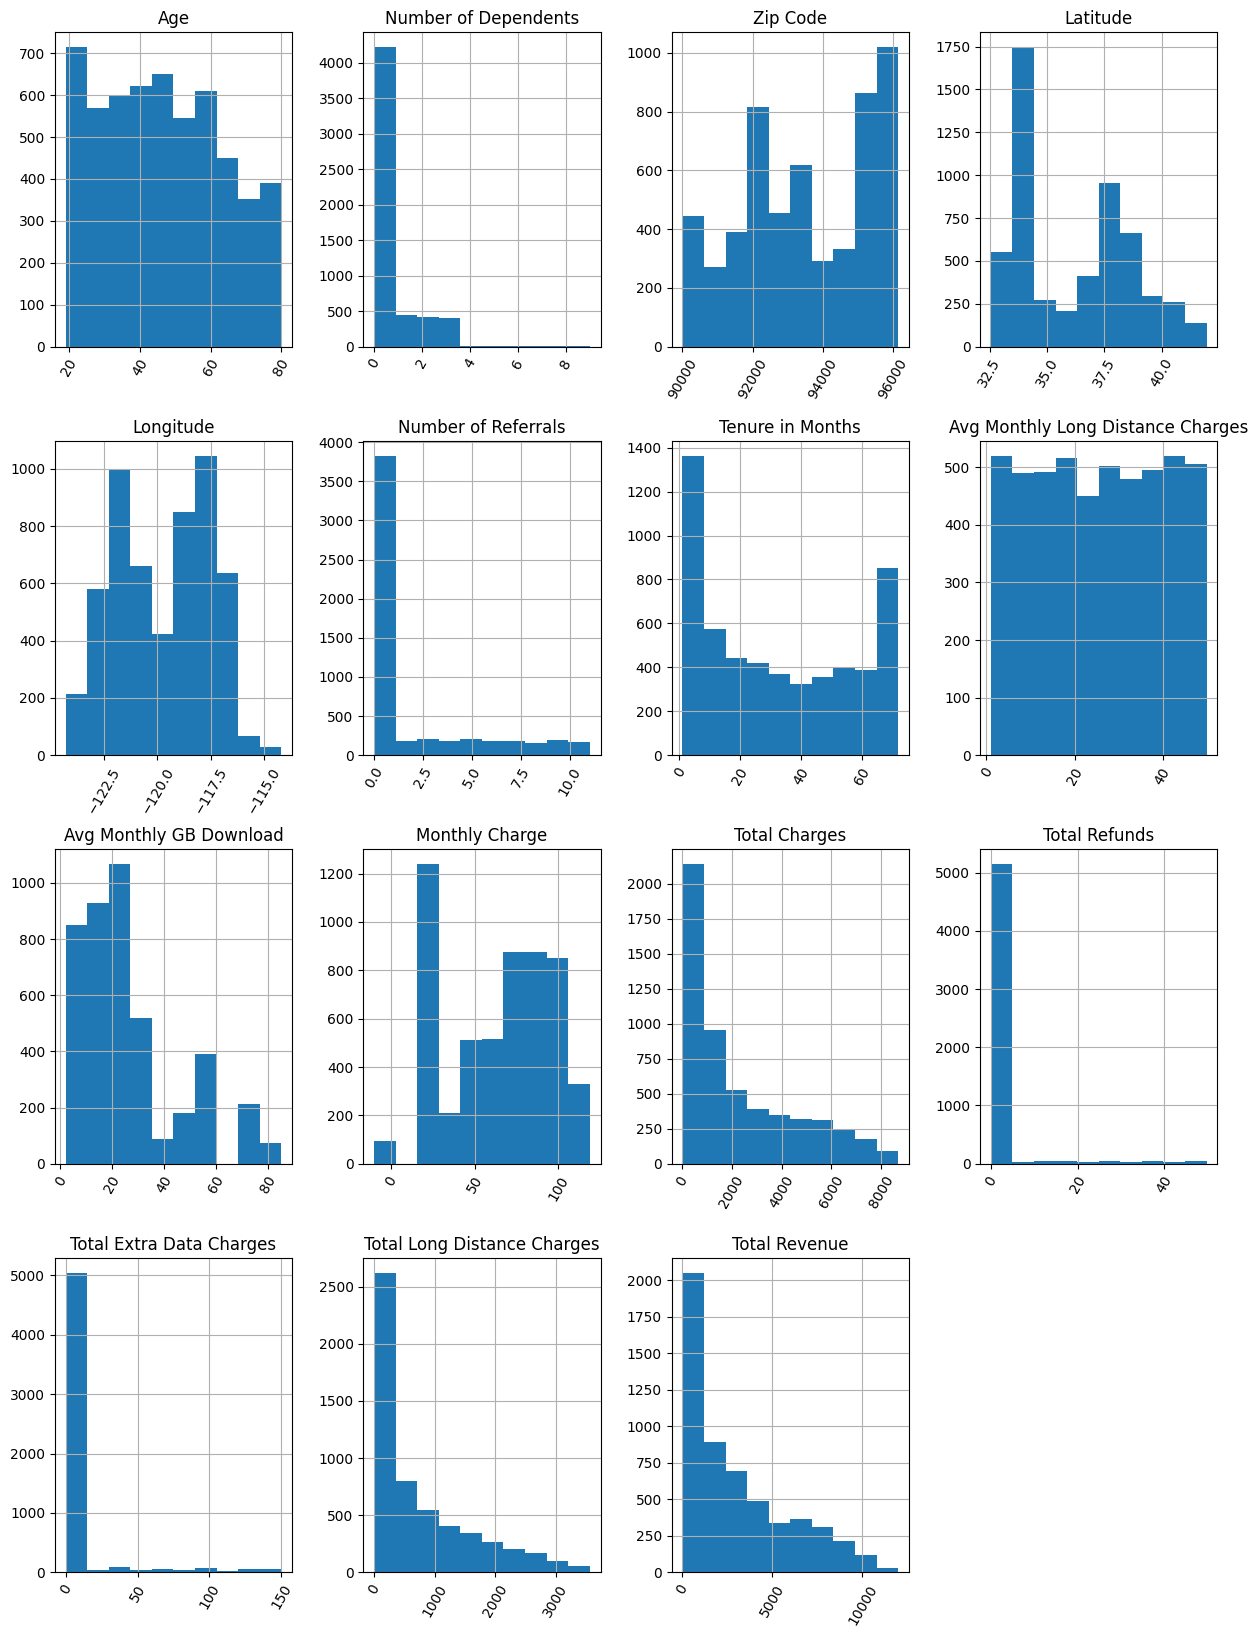

In [58]:
train_df.hist(figsize=(15, 20), xrot=60)

Đồ thị này cung cấp một cái nhìn tổng quan về nhiều khía cạnh của dữ liệu khách hàng. Phân bố độ tuổi khá đều, với số lượng cao nhất ở nhóm 20-25. Đa số khách hàng không có người phụ thuộc. Số lượng giới thiệu thấp, với đa số khách hàng không giới thiệu ai. Thời gian sử dụng dịch vụ đa dạng, phần lớn khách hàng dùng từ 0 đến 20 tháng. Phí hàng tháng tập trung ở mức trung bình (phần đông trả 20 đến 25$ một tháng). Tổng chi phí càng cao thì số lượng khác hàng càng giảm. Phí dữ liệu phụ trội và cước gọi đường dài chủ yếu ở mức thấp với hầu hết khách hàng.

### Phân tích đa biến

In [59]:
# encode customer status
class_dict = {'Stayed': 0, 'Churned': 1, 'Joined': 0}
train_df = train_df.replace({'Customer Status': class_dict})
test_df = test_df.replace({'Customer Status': class_dict})

/var/folders/y9/m40hlc6x15lfjy_pyh828dbc0000gn/T/ipykernel_4648/1536720470.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df = train_df.replace({'Customer Status': class_dict})
/var/folders/y9/m40hlc6x15lfjy_pyh828dbc0000gn/T/ipykernel_4648/1536720470.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df = test_df.replace({'Customer Status': class_dict})


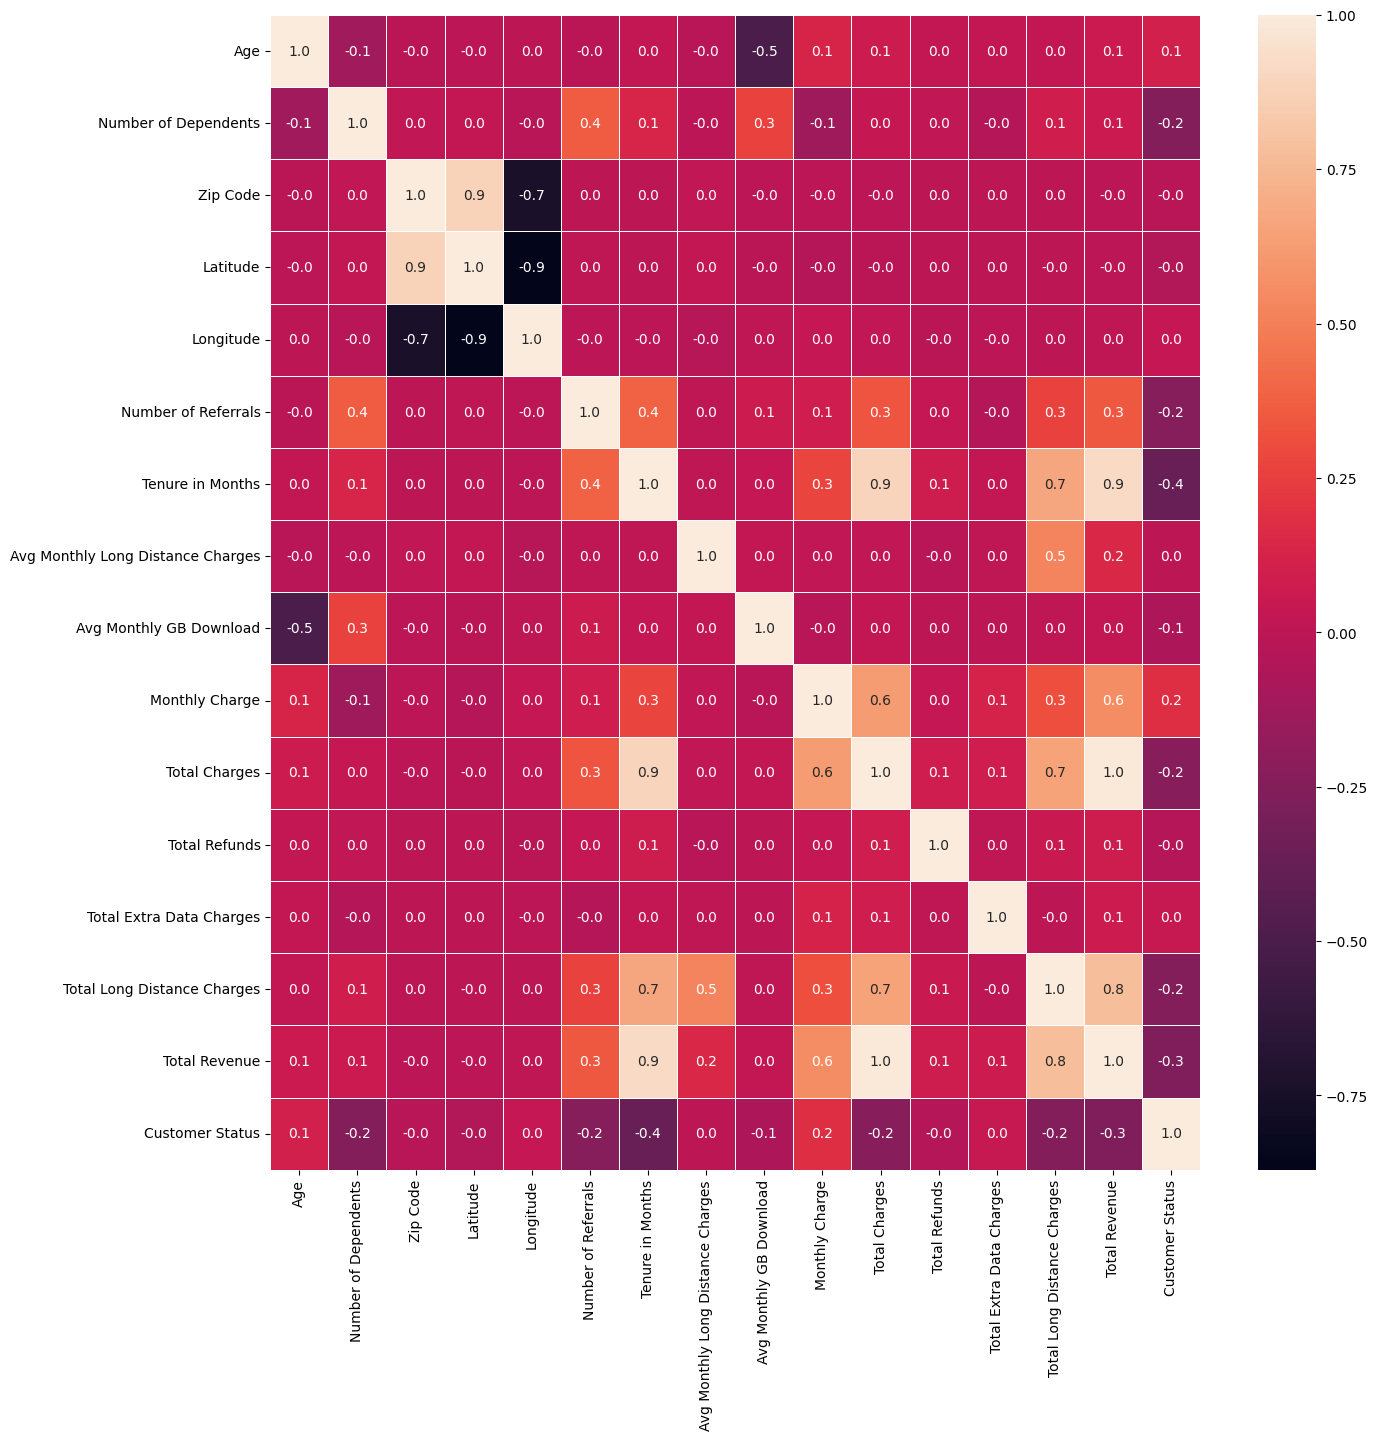

In [60]:
numeric_train_df = train_df.select_dtypes(include=[np.number])
fig, ax = plt.subplots(figsize=(15, 15))
axes = sns.heatmap(numeric_train_df.corr('spearman'), annot=True, ax=ax, linewidths=.5, fmt='.1f', cmap='rocket')

Tổng doanh thu có tương quan mạnh với tổng chi phí, thời gian sử dụng dịch vụ và cước gọi đường dài. Mã bưu điện, vĩ độ và kinh độ có mối liên hệ chặt chẽ, phản ánh vị trí địa lý. Thời gian sử dụng dịch vụ ảnh hưởng tích cực đến nhiều yếu tố như số lượng giới thiệu, chi phí hàng tháng và tổng chi phí. 

### Trực quan hoá các thuộc tính phân loại có liên quan đến khả năng rời bỏ dịch vụ

<Axes: xlabel='Tenure in Months', ylabel='Monthly Charge'>

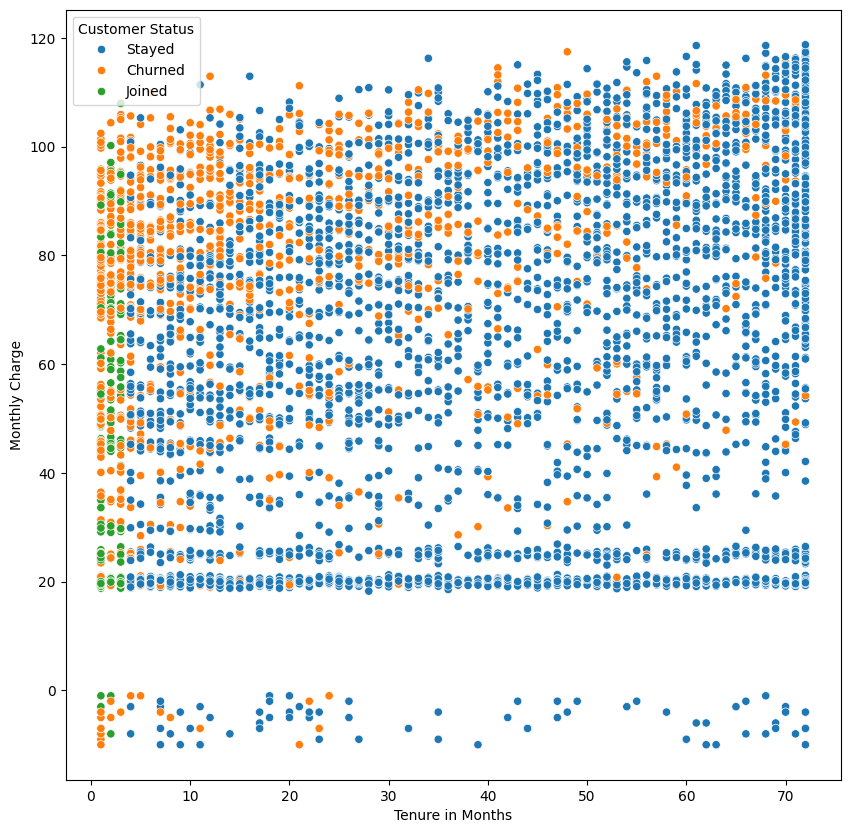

In [38]:
# scatterplot of tenure in months vs. monthly charge (with labels)
plt.figure(figsize=(10, 10))
sns.scatterplot(data=train_df, x='Tenure in Months', y='Monthly Charge', hue='Customer Status')

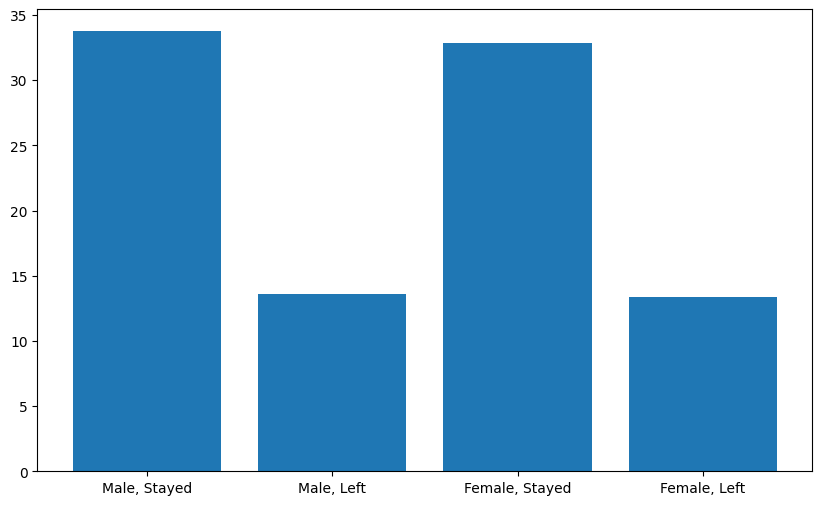

In [7]:
# proporion between male and female customers who stayed and left
male_stayed = train_df[(train_df['Customer Status'] == 'Stayed') & (train_df['Gender'] == 'Male')].shape[0] / train_df.shape[0] * 100
male_left = train_df[(train_df['Customer Status'] == 'Churned') & (train_df['Gender'] == 'Male')].shape[0] / train_df.shape[0] * 100
female_stayed = train_df[(train_df['Customer Status'] == 'Stayed') & (train_df['Gender'] == 'Female')].shape[0] / train_df.shape[0] * 100
female_left = train_df[(train_df['Customer Status'] == 'Churned') & (train_df['Gender'] == 'Female')].shape[0] / train_df.shape[0] * 100

plt.figure(figsize=(10, 6))
bars = plt.bar(['Male, Stayed', 'Male, Left', 'Female, Stayed', 'Female, Left'], [male_stayed, male_left, female_stayed, female_left])

### 2.1: Thời gian gắn bó trung bình của khách hàng và khoản tiền phải đóng mỗi tháng

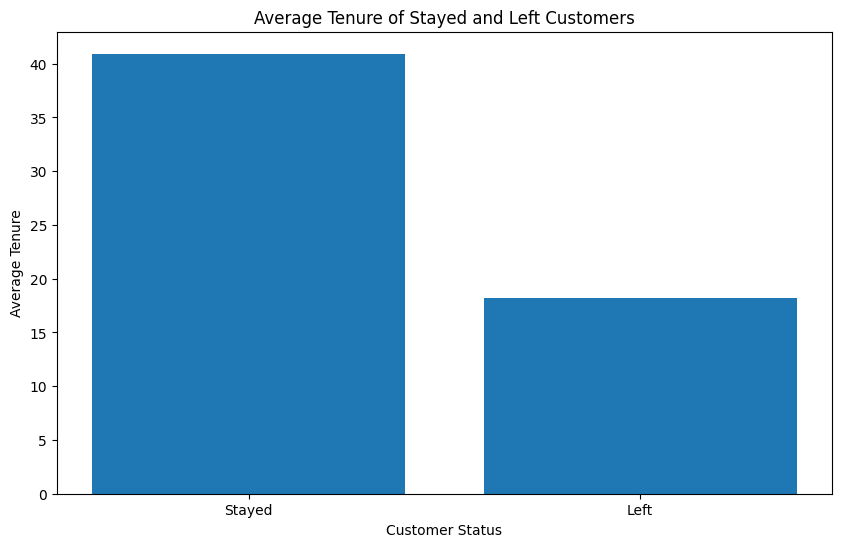

In [8]:
# find the number of stayed and left customers
stayed_customers = train_df[train_df['Customer Status'] == 'Stayed']
left_customers = train_df[train_df['Customer Status'] == 'Churned']

# calculate average tenure of stayed and left customers
stayed_tenure = stayed_customers['Tenure in Months'].mean()
left_tenure = left_customers['Tenure in Months'].mean()

plt.figure(figsize=(10, 6))
plt.bar(['Stayed', 'Left'], [stayed_tenure, left_tenure])
plt.title('Average Tenure of Stayed and Left Customers')
plt.xlabel('Customer Status')
plt.ylabel('Average Tenure')
plt.show()

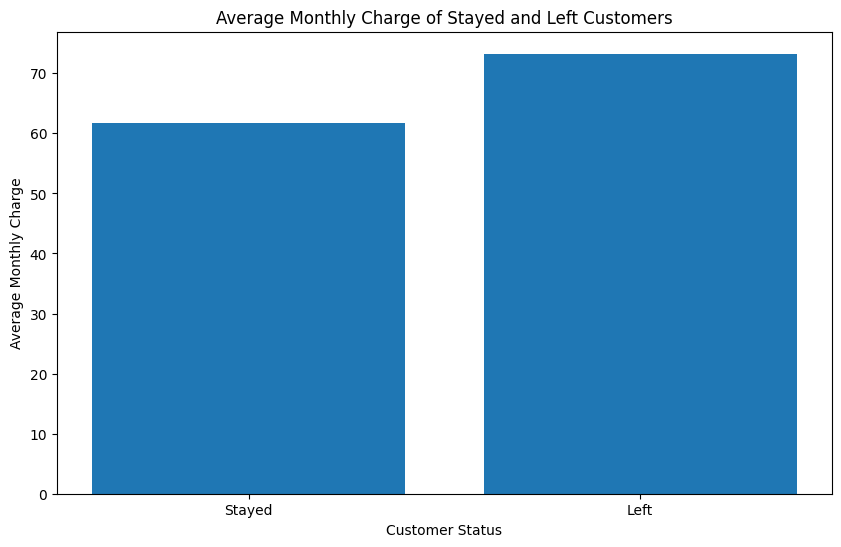

In [9]:
# find average monthly charge of stayed and left customers
stayed_monthly_charge = stayed_customers['Monthly Charge'].mean()
left_monthly_charge = left_customers['Monthly Charge'].mean()

plt.figure(figsize=(10, 6))
plt.bar(['Stayed', 'Left'], [stayed_monthly_charge, left_monthly_charge])
plt.title('Average Monthly Charge of Stayed and Left Customers')
plt.xlabel('Customer Status')
plt.ylabel('Average Monthly Charge')
plt.show()

### 2.2. Phân tích những biến có liên quan với tỉ lệ rời bỏ khách hàng

Thời gian gắn bó trung bình của khách hàng: Biểu đồ cho thấy thời gian gắn bó trung bình của những khách hàng ở lại là 42 tháng trong khi thời gian gắn bó trung bình của khách hàng rời bỏ là 10 tháng. Trong số những vị khách rời bỏ, có những trường hợp đã gắn bó hơn 70 tháng

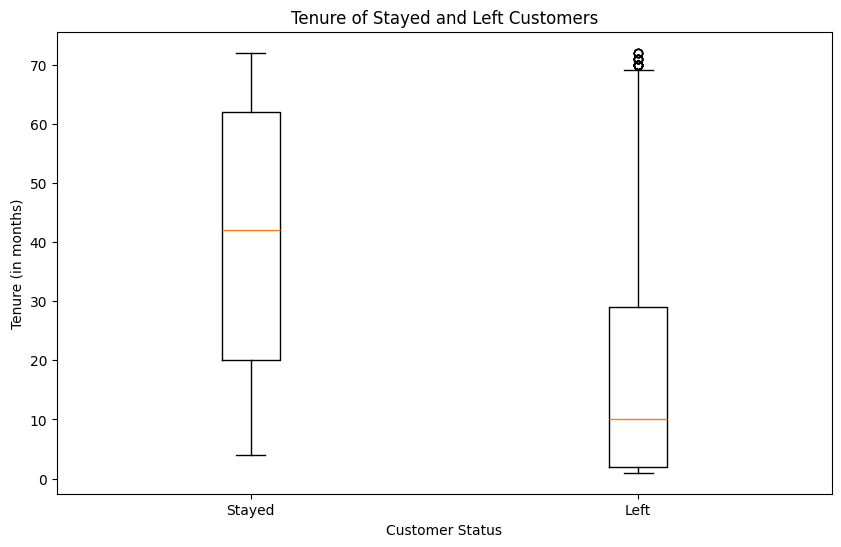

In [10]:
# draw boxplot of tenure of stayed and left customers
plt.figure(figsize=(10, 6))
plt.boxplot([stayed_customers['Tenure in Months'], left_customers['Tenure in Months']], tick_labels=['Stayed', 'Left'])
plt.title('Tenure of Stayed and Left Customers')
plt.xlabel('Customer Status')
plt.ylabel('Tenure (in months)')
plt.show()

Khoản tiền đóng mỗi tháng: Khoản tiền đóng mỗi tháng của nhóm khách ở lại có median là 67, trong khi nhóm rời bỏ có median là 80.

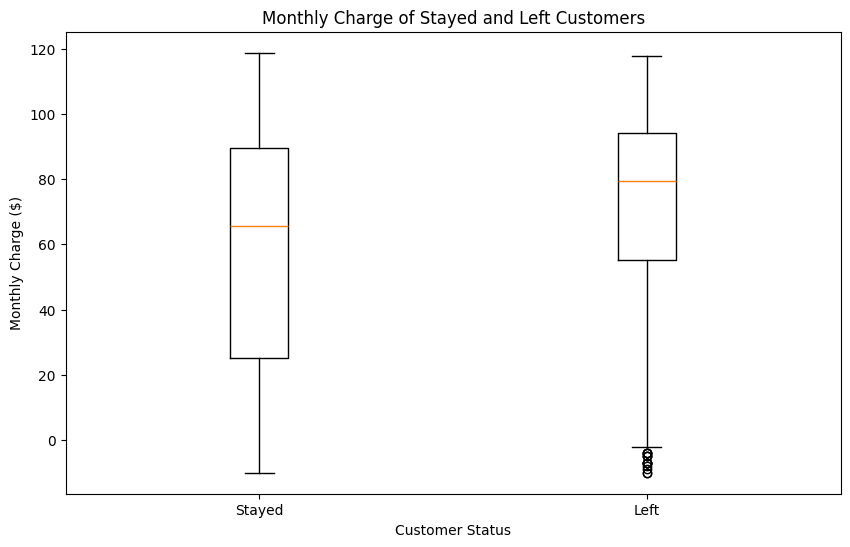

In [11]:
# draw boxplot of monthly charge of stayed and left customers
plt.figure(figsize=(10, 6))
plt.boxplot([stayed_customers['Monthly Charge'], left_customers['Monthly Charge']], tick_labels=['Stayed', 'Left'])
plt.title('Monthly Charge of Stayed and Left Customers')
plt.xlabel('Customer Status')
plt.ylabel('Monthly Charge ($)')
plt.show()

Tổng tiền đóng: Tổng tiền đã đóng của nhóm ở lại có median là 2000 trong khi tổng tiền đóng của nhóm rời đi là 1300.

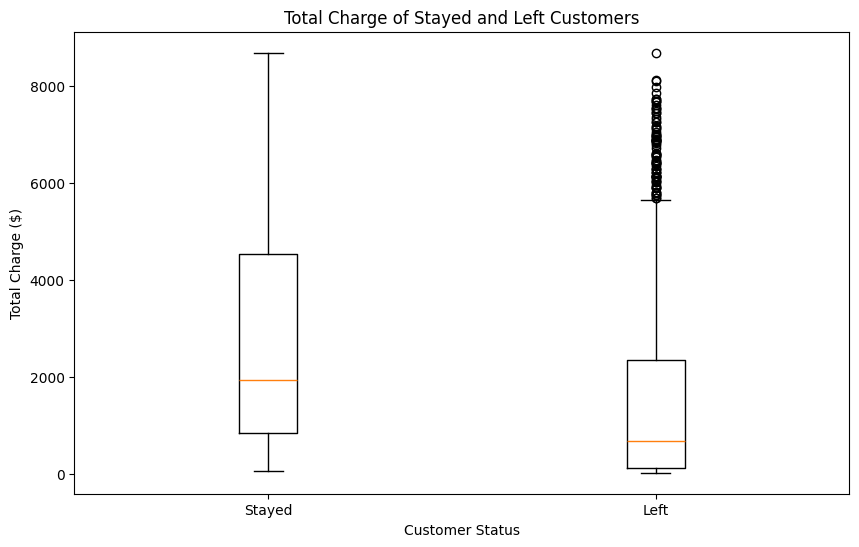

In [12]:
# boxplot of total charge of stayed and left customers
plt.figure(figsize=(10, 6))
plt.boxplot([stayed_customers['Total Charges'], left_customers['Total Charges']], tick_labels=['Stayed', 'Left'])
plt.title('Total Charge of Stayed and Left Customers')
plt.xlabel('Customer Status')
plt.ylabel('Total Charge ($)')
plt.show()